# Reframe dataset

During this process I will select a specific pollutant to forecast along with exegenous variables that can influence its values, and reframe the current information as a supervised learning dataset. This step is necessary so that the LTSM can be correctly trained with the data it's given.

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from math import sqrt

In [25]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [30]:
import optuna # Hyperparameter optimization

/Users/valeriagonzalez/Documents/aqi/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
filename = "semadet-aire-final"
filepath = f"datasets/feature_eng/{filename}.csv"
df = pd.read_csv(filepath, parse_dates=[0], index_col=0)

## Select pollutant to predict and exegenous variables

The first dataset to reframe will contain PM2.5 as the independent variable and temperature, relative humidity, wind speed and wind direction as the dependent variables.

In [4]:
features = ["pm25", "tmp", "rh", "ws", "wd"]
pollutant = "pm25"

In [5]:
def select_df_features(df:pd.DataFrame, features:list):
    df_select = pd.DataFrame()
    for feature in features:
        df_select[feature] = df[feature]
    return df_select

In [6]:
df_select = select_df_features(df, features)

In [7]:
df_select.head(3)

,pm25,tmp,rh,ws,wd
date,,,,,
2017-01-01,24.869231,19.475000,52.125000,2.516667,9.648721
2017-01-02,24.869231,19.358333,49.691667,1.291667,9.957045
2017-01-03,24.869231,19.970833,43.037500,1.062500,11.695896


## Normalize data

Once the data is separated, it's important to normalize all the values. The data will be transformed to a common scale to improve the model's performance. In this case, the data held for each feature will be scaled to have values between 0 and 1.

In [8]:
data_scaler = MinMaxScaler(feature_range=(0,1))
data_norm = data_scaler.fit_transform(df_select.values)

In [9]:
data_norm[:5]

array([[0.22140047, 0.43233533, 0.54997636, 0.43192939, 0.02718241],
       [0.22140047, 0.42517661, 0.51689848, 0.21843369, 0.02805866],
       [0.22140047, 0.46275987, 0.42644408, 0.17849402, 0.03300044],
       [0.22140047, 0.50264415, 0.36096801, 0.20173165, 0.03609954],
       [0.22140047, 0.57934468, 0.26972064, 0.40723941, 0.04108343]])

## Timeseries to supervised learning

In [10]:
def series_to_supervised(data, column_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f"{column_names[j]}(t-{i})") for j in range(n_vars)]
    
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f"{column_names[j]}(t)") for j in range(n_vars)]
        else:
            names += [(f"{column_names[j]}(t+{i})") for j in range(n_vars)]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [11]:
data_reframed = series_to_supervised(data_norm, features, 1, 1)

In [12]:
# drop columns we don't want to predict (i.e, drop all features that aren't pm25 for time t)
data_reframed.drop(data_reframed.columns[[6,7,8,9]], axis=1, inplace=True)

In [13]:
data_reframed.head(3)

,pm25(t-1),tmp(t-1),rh(t-1),ws(t-1),wd(t-1),pm25(t)
1,0.2214,0.432335,0.549976,0.431929,0.027182,0.2214
2,0.2214,0.425177,0.516898,0.218434,0.028059,0.2214
3,0.2214,0.462760,0.426444,0.178494,0.033000,0.2214


## Divide dataset

In [14]:
def divide_series(df: pd.DataFrame, train:float=0.65, val:float=0.15):
    data_len = len(df)
    train_size = int(data_len * train)
    val_size = int(data_len * val)
    
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for feature in df.columns:
        train_df[feature] = df[feature][:train_size]
        val_df[feature] = df[feature][train_size:train_size + val_size]
        test_df[feature] = df[feature][train_size + val_size:]
    

    return train_df, val_df, test_df

In [15]:
train_df, val_df, test_df = divide_series(data_reframed, train=0.56, val=0.10)

In [16]:
print(f"Train set len: {len(train_df)}")
print(f"Validation set len: {len(val_df)}")
print(f"Test set len: {len(test_df)}")

Train set len: 613
Validation set len: 109
Test set len: 373


In [17]:
train_df.head(3)

,pm25(t-1),tmp(t-1),rh(t-1),ws(t-1),wd(t-1),pm25(t)
1,0.2214,0.432335,0.549976,0.431929,0.027182,0.2214
2,0.2214,0.425177,0.516898,0.218434,0.028059,0.2214
3,0.2214,0.462760,0.426444,0.178494,0.033000,0.2214


In [18]:
# train_df.to_csv(f"datasets/reframe/train_{pollutant}.csv", index=False)
# val_df.to_csv(f"datasets/reframe/val_{pollutant}.csv", index=False)
# test_df.to_csv(f"datasets/reframe/test_{pollutant}.csv",index=False)


Split the data into inputs and outputs

In [19]:
train_values = train_df.values
val_values = val_df.values
test_values = test_df.values
print(train_values.shape)

(613, 6)


In [20]:
train_X, train_y = train_values[:,:-1], train_values[:,-1]
val_X, val_y = val_values[:,:-1], val_values[:,-1]
test_X, test_y = test_values[:,:-1], test_values[:,-1]

Reshape the input to be 3d format [samples, timesteps, features]

In [41]:
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
val_X = val_X.reshape(val_X.shape[0], 1, val_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

ValueError: cannot reshape array of size 3065 into shape (613,1,1)

In [54]:
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [56]:
print(train_X.shape, val_X.shape, test_X.shape)
print(train_y.shape, val_y.shape, test_y.shape)

(613, 1, 5) (109, 1, 5) (373, 1, 5)
(613,) (109,) (373,)


In [55]:
test_y = test_y.reshape(test_y.shape[0])

## Define and fit ltsm. 

In [31]:
class MLPOptimizer:
  """
  Class for hyperparameter optimizing for PM2.5 Forecaster.
  """
  def __init__(self, input_dim:int, n_trials:int):
    self.input_dim = input_dim
    self.n_trials = n_trials
    self.study = None
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None

  def create_model(self, trial):
    model = Sequential()

    # Hyperparameter selection
    neurons = trial.suggest_categorical("neurons", [5, 50])
    # dropout_rate = trial.suggest_float("dropout", 0.1, 0.2, log=True)
    
    model.add(LSTM(neurons, 
                   input_shape=(self.X_train.shape[1], self.X_train.shape[2]),
                   activation="relu"))


    # Dropout layer
    # model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile model
    # learning_rate = trial.suggest_cat("learning_rate", 0.001, 0., log=True)
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate), loss="mse")

    return model

  def objective(self, trial):
    model = self.create_model(trial)
    epochs = trial.suggest_categorical("epochs", [50, 100])

    # Train the model
    model.fit(
        self.X_train,
        self.y_train,
        epochs=epochs,
        validation_data=(self.X_val, self.y_val),
        verbose=0
        )

    # Evaluate on validation data
    loss = model.evaluate(self.X_val, self.y_val, verbose=0)

    return loss

  def optimize(self, X_train:np.array, y_train:np.array, X_val, y_val:np.array):
    self.X_train = X_train
    self.y_train = y_train
    self.X_val = X_val
    self.y_val = y_val

    self.study = optuna.create_study(direction="minimize")
    self.study.optimize(self.objective, n_trials = self.n_trials)

    print("Best hyperparameters:", self.study.best_params)
    return self.study

In [32]:
n_steps = 1

In [33]:
mlp_optimizer = MLPOptimizer(n_steps, 32)
study = mlp_optimizer.optimize(train_X, train_y, val_X, val_y)

[I 2025-04-03 19:49:11,011] A new study created in memory with name: no-name-5f687950-080e-4171-9fe9-557d30299ac8
/Users/valeriagonzalez/Documents/aqi/env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-03 19:49:14,461] Trial 0 finished with value: 0.0044375634752213955 and parameters: {'neurons': 5, 'epochs': 100}. Best is trial 0 with value: 0.0044375634752213955.
[I 2025-04-03 19:49:16,466] Trial 1 finished with value: 0.004448600113391876 and parameters: {'neurons': 50, 'epochs': 50}. Best is trial 0 with value: 0.0044375634752213955.
[I 2025-04-03 19:49:18,500] Trial 2 finished with value: 0.005482207052409649 and parameters: {'neurons': 5, 'epochs': 50}. Best is trial 0 with value: 0.0044375634752213955.
[I 2025-04-03 19:49:22,292] Trial 3 finishe

Best hyperparameters: {'neurons': 50, 'epochs': 100}


The first layer in the network must define the number of inputs to expect. Input must be three-dimensional, comprised of samples, timesteps, and features.

/Users/valeriagonzalez/Documents/aqi/env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


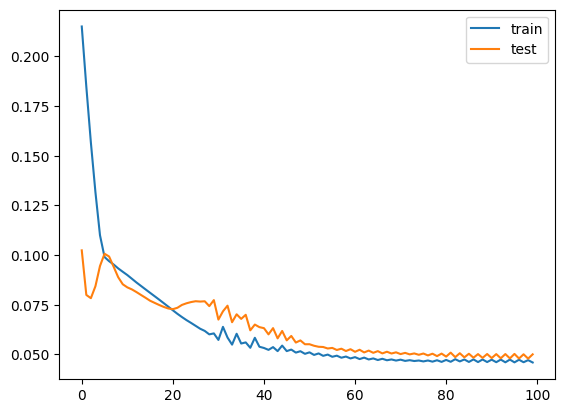

In [53]:
# design network
model = Sequential()
model.add(LSTM(50, 
               input_shape=(train_X.shape[1], train_X.shape[2]),
               activation="relu"))
model.add(Dense(1))
model.compile(loss='mae', optimizer=Adam(0.001))
# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=100, 
    batch_size=72, 
    validation_data=(val_X, val_y),
    verbose=0, 
    shuffle=False
    )
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [57]:
# make a prediction
yhat = model.predict(test_X)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
# invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = data_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Test RMSE: 12.003


In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = data_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
for i in range(0, len(inv_y)):
    print(f"Actual: {inv_y[i]}  Predict: {inv_yhat[i]}")

Actual: 33.54545454545455  Predict: 28.42788571678102
Actual: 33.54545454545455  Predict: 28.876362567022444
Actual: 33.54545454545455  Predict: 30.476809175685048
Actual: 33.54545454545455  Predict: 28.384192102029917
Actual: 33.54545454545455  Predict: 29.33955514729023
Actual: 33.54545454545455  Predict: 29.931567971780897
Actual: 33.54545454545455  Predict: 28.828732306510208
Actual: 33.54545454545455  Predict: 28.422316684946416
Actual: 18.194166666666668  Predict: 28.018678302690386
Actual: 18.194166666666668  Predict: 18.84549689050764
Actual: 24.24833333333333  Predict: 18.403485307842494
Actual: 42.72625  Predict: 22.395782578736544
Actual: 66.06416666666667  Predict: 34.81573986969888
Actual: 53.97125  Predict: 52.01404290050267
Actual: 55.071250000000006  Predict: 43.61932651735842
Actual: 47.17625  Predict: 43.21614413596689
Actual: 50.98  Predict: 37.38232860788703
Actual: 60.373333333333335  Predict: 40.62854054942727
Actual: 62.60583333333333  Predict: 47.54869324341416
